This is a Demo for using the kde1D interpolator provided in ctntools git repository 'https://github.com/ctnelson/ctntools.git'

This is a method to interpolate unstructured data onto an interpolation grid, written for gpu optimization.
Three variations are provided:
'Round' :    assigns the full value of each datapoint to the closest grid point & convolves the kernel (This functionality will behave like generating a histogram + smoothing by the selected kernel)
'Interp':    linearly interpolates full value of each datapoint to the bounding grid points & convolves the kernel (This is functionality you will get with interpolation functions like griddata + smoothing...)
'exact' :    calculates the real-space solution convolving the kernel exactly at all datapoints agnostic of the interpolation grid. The interpolation grid only samples the solution.

Two available kernels:
Gaussian
Bump Function   (exact operation not currently available)

Created 2024 by Dr. Christopher Nelson
Oak Ridge National Laboratory

Standard Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from git import Repo,  InvalidGitRepositoryError

Custom GIT Imports

In [2]:
gitlocal = ''
for i in sys.path:
    temp=i.split('\\')
    if temp[-1]=='site-packages':
        gitlocal=i

In [3]:
#Set local git repository location
gitremote = 'https://github.com/ctnelson/ctntools.git'
gitl = os.path.join(gitlocal,'ctntools')
print(gitl)

c:\programs\Anaconda3\envs\gpuenv\lib\site-packages\ctntools


In [4]:
#check for local repo, pull if found
#clone git repo if not found locally
if os.path.exists(gitl):
    try:
        my_repo = Repo(gitl)
        o = my_repo.remotes.origin
        o.pull()
    except InvalidGitRepositoryError:
        Repo.clone_from(gitremote, gitl)
        my_repo = Repo(gitl)
else:
    Repo.clone_from(gitremote, gitl)
    my_repo = Repo(gitl)
print(my_repo)

<git.repo.base.Repo 'c:\\programs\\Anaconda3\\envs\\gpuenv\\lib\\site-packages\\ctntools\\.git'>


In [5]:
#Import custom functions from git repo
from ctntools.Convolution.kde1D import kde1D

KDE with Gaussian kernels

In [6]:
#kde1D Demo
s = 1                                   #sigma
x = s*np.array([5.5, 8, 9, 18.25])      #datapoint x positions (multiplied by s so these are in units of sigma)
y = np.array([3, 7, 4, 2])              #datapoint values
xstp = 1                                #interpolation stepsize
xgrd = np.arange(0,np.max(x)+5,xstp)    #interpolation grid


#Rounding
distr_r, density_r, k_r = kde1D(x, y, xgrd, s=s, method='round')
#Interpolation
distr_i, density_i, k_i = kde1D(x, y, xgrd, s=s)
#Exact
distr_e, density_e, k_e = kde1D(x, y, xgrd, s=s, method='exact')

c:\programs\Anaconda3\envs\gpuenv\lib\site-packages\numba\cuda\compiler.py:726: NumbaPerformanceWarning: Grid size (1) < 2 * SM count (26) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
c:\programs\Anaconda3\envs\gpuenv\lib\site-packages\numba\cuda\compiler.py:726: NumbaPerformanceWarning: Grid size (1) < 2 * SM count (26) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


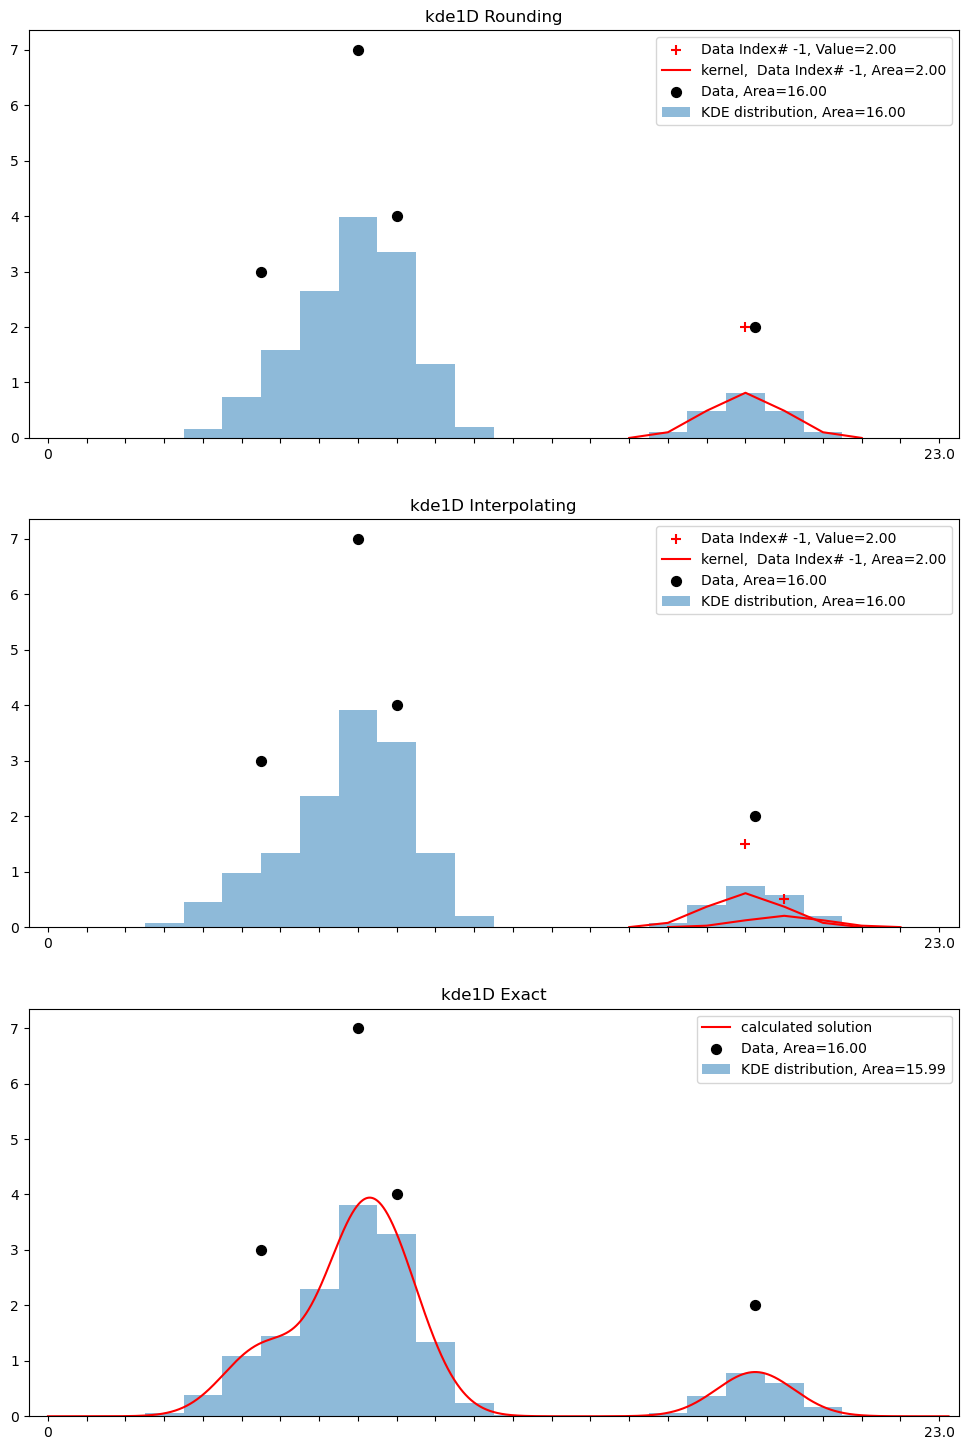

In [7]:
#plot Results
i=-1                #select a datapoint (index) to highlight

fig, ax = plt.subplots(3, 1, figsize=(12, 18), dpi = 100)

maxticks = 20
tickstp = np.max(np.array([np.modf(xgrd.size/maxticks)[1],1]))
tickpos = np.arange(0,xgrd.size,tickstp.astype('int'))
ticklbls = ['']*tickpos.size
ticklbls[0] = 0
ticklbls[-1] = xgrd[tickpos[-1]]

### Round ###
x0 = np.round(x[i]/xstp)*xstp
kr = (k_r.size-1)/2   #kernal distance from center
ax[0].set_title('kde1D Rounding')
ax[0].scatter(x0, y[i],c='r',s=50, marker='+', zorder=2, label='Data Index# {:d}, Value={:.2f}'.format(i,y[i]))
ax[0].plot(np.arange(-kr,kr+1)*xstp+x0, k_r*y[i]/xstp ,'-r',label='kernel,  Data Index# {:d}, Area={:.2f}'.format(i,np.sum(k_r*y[i])))
ax[0].bar(xgrd, distr_r/xstp, width=xstp, alpha=.5, zorder=0, label='KDE distribution, Area={:.2f}'.format(np.nansum(distr_r)))
ax[0].scatter(x, y,c='k',s=50,zorder=1, label='Data, Area={:.2f}'.format(np.sum(y)))
#display parameters
ax[0].set_xlim([-xstp/2,xgrd[-1]+xstp/2])
ax[0].set_xticks(xgrd[tickpos])
ax[0].set_xticklabels(ticklbls)
ax[0].legend()

### Interp ###
x0 = np.floor(x[i]/xstp)
xH = np.mod(x[i]/xstp,1)
x0 = x0*xstp
kr = (k_i.size-1)/2
ax[1].set_title('kde1D Interpolating')
ax[1].scatter(x0, y[i]*(1-xH), c='r',s=50, marker='+', zorder=2, label='Data Index# {:d}, Value={:.2f}'.format(i,y[i]))
ax[1].plot(np.arange(-kr,kr+1)*xstp+x0, k_i*y[i]*(1-xH)/xstp ,'-r',label='kernel,  Data Index# {:d}, Area={:.2f}'.format(i,np.sum(k_i*y[i]*((1-xH)+xH))))
ax[1].scatter(x0+xstp, y[i]*xH, c='r',s=50, marker='+', zorder=2)
ax[1].plot(np.arange(-kr,kr+1)*xstp+x0+xstp, k_i*y[i]*xH/xstp ,'-r')
ax[1].bar(xgrd, distr_i/xstp, width=xstp, alpha=.5, zorder=0, label='KDE distribution, Area={:.2f}'.format(np.nansum(distr_r)))
ax[1].scatter(x, y,c='k',s=50,zorder=1, label='Data, Area={:.2f}'.format(np.sum(y)))
#display parameters
ax[1].set_xlim([-xstp/2,xgrd[-1]+xstp/2])
ax[1].set_xticks(xgrd[tickpos])
ax[1].set_xticklabels(ticklbls)
ax[1].legend()

### Exact ###
xx = np.arange(0,np.max(x)+5,xstp/100)
yk = np.zeros_like(xx)
for i in range(x.size):
    x0 = x[i]
    yk += y[i]*1/(2*np.pi)**.5/s*np.exp(-(xx-x0)**2/2/s**2)
ax[2].set_title('kde1D Exact')
ax[2].plot(xx, yk ,'-r',label='calculated solution')
ax[2].bar(xgrd, distr_e, width=xstp, alpha=.5, zorder=0, label='KDE distribution, Area={:.2f}'.format(np.trapz(distr_e,x=xgrd)))
ax[2].scatter(x, y,c='k',s=50,zorder=1, label='Data, Area={:.2f}'.format(np.sum(y)))
#display parameters
ax[2].set_xlim([-xstp/2,xgrd[-1]+xstp/2])
ax[2].set_xticks(xgrd[tickpos])
ax[2].set_xticklabels(ticklbls)
ax[2].legend()

KDE with Bump kernels

In [8]:
s = 1                                   #sigma
x = s*np.array([5.5, 8, 9, 18.25])      #datapoint x positions (multiplied by s so these are in units of sigma)
y = np.array([3, 7, 4, 2])              #datapoint values
xstp = 1                                #interpolation stepsize
xgrd = np.arange(0,np.max(x)+5,xstp)    #interpolation grid


#Rounding
distr_r, density_r, k_r = kde1D(x, y, xgrd, s=s, kernel='Bump', method='round')
#Interpolation
distr_i, density_i, k_i = kde1D(x, y, xgrd, s=s, kernel='Bump')

c:\programs\Anaconda3\envs\gpuenv\lib\site-packages\numba\cuda\compiler.py:726: NumbaPerformanceWarning: Grid size (1) < 2 * SM count (26) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


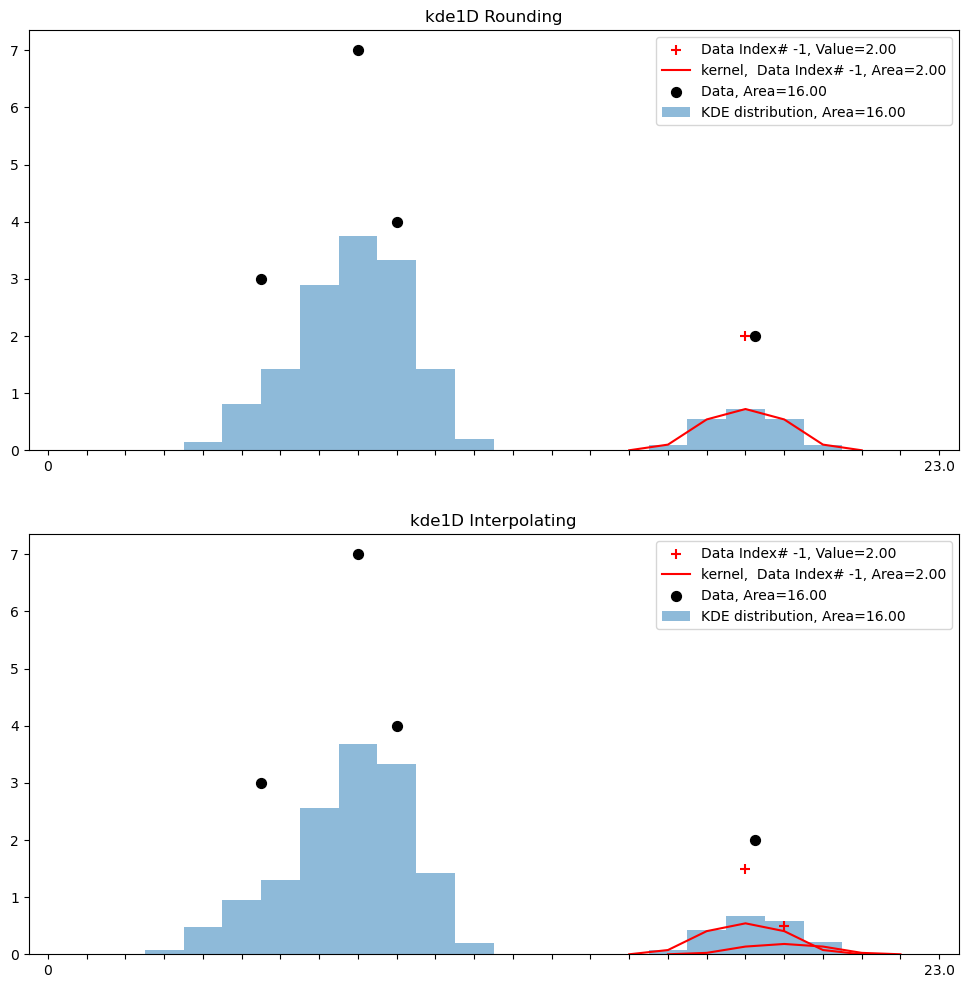

In [9]:

#plot Results
i=-1                #select a datapoint (index) to highlight

fig, ax = plt.subplots(2, 1, figsize=(12, 12), dpi = 100)

maxticks = 20
tickstp = np.max(np.array([np.modf(xgrd.size/maxticks)[1],1]))
tickpos = np.arange(0,xgrd.size,tickstp.astype('int'))
ticklbls = ['']*tickpos.size
ticklbls[0] = 0
ticklbls[-1] = xgrd[tickpos[-1]]

### Round ###
x0 = np.round(x[i]/xstp)*xstp
kr = (k_r.size-1)/2   #kernal distance from center
ax[0].set_title('kde1D Rounding')
ax[0].scatter(x0, y[i],c='r',s=50, marker='+', zorder=2, label='Data Index# {:d}, Value={:.2f}'.format(i,y[i]))
ax[0].plot(np.arange(-kr,kr+1)*xstp+x0, k_r*y[i]/xstp ,'-r',label='kernel,  Data Index# {:d}, Area={:.2f}'.format(i,np.sum(k_r*y[i])))
ax[0].bar(xgrd, distr_r/xstp, width=xstp, alpha=.5, zorder=0, label='KDE distribution, Area={:.2f}'.format(np.nansum(distr_r)))
ax[0].scatter(x, y,c='k',s=50,zorder=1, label='Data, Area={:.2f}'.format(np.sum(y)))
#display parameters
ax[0].set_xlim([-xstp/2,xgrd[-1]+xstp/2])
ax[0].set_xticks(xgrd[tickpos])
ax[0].set_xticklabels(ticklbls)
ax[0].legend()

### Interp ###
x0 = np.floor(x[i]/xstp)
xH = np.mod(x[i]/xstp,1)
x0 = x0*xstp
kr = (k_i.size-1)/2
ax[1].set_title('kde1D Interpolating')
ax[1].scatter(x0, y[i]*(1-xH), c='r',s=50, marker='+', zorder=2, label='Data Index# {:d}, Value={:.2f}'.format(i,y[i]))
ax[1].plot(np.arange(-kr,kr+1)*xstp+x0, k_i*y[i]*(1-xH)/xstp ,'-r',label='kernel,  Data Index# {:d}, Area={:.2f}'.format(i,np.sum(k_i*y[i]*((1-xH)+xH))))
ax[1].scatter(x0+xstp, y[i]*xH, c='r',s=50, marker='+', zorder=2)
ax[1].plot(np.arange(-kr,kr+1)*xstp+x0+xstp, k_i*y[i]*xH/xstp ,'-r')
ax[1].bar(xgrd, distr_i/xstp, width=xstp, alpha=.5, zorder=0, label='KDE distribution, Area={:.2f}'.format(np.nansum(distr_r)))
ax[1].scatter(x, y,c='k',s=50,zorder=1, label='Data, Area={:.2f}'.format(np.sum(y)))
#display parameters
ax[1].set_xlim([-xstp/2,xgrd[-1]+xstp/2])
ax[1].set_xticks(xgrd[tickpos])
ax[1].set_xticklabels(ticklbls)
ax[1].legend()